In [1]:
# !pip install simpeg matplotlib-scalebar choclo discretize deepdish pyvista  geopandas

In [2]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import tarfile
import urllib.request

from discretize import TensorMesh
from discretize.utils import active_from_xyz
from simpeg.utils import plot2Ddata, model_builder
from simpeg.potential_fields import gravity
from simpeg import (
    maps,
    data,
    data_misfit,
    inverse_problem,
    regularization,
    optimization,
    directives,
    inversion,
    utils,
)

import numpy as np
import matplotlib.pyplot as plt
from discretize import TreeMesh
from discretize.utils import mkvc

# sphinx_gallery_thumbnail_number = 3

In [3]:

import matplotlib
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import tarfile

from discretize import TensorMesh

# from SimPEG.potential_fields import magnetics
# from SimPEG import dask
# from SimPEG.utils import plot2Ddata, surface2ind_topo
from SimPEG import (
    maps,
    data,
    inverse_problem,
    data_misfit,
    regularization,
    optimization,
    directives,
    inversion,
    utils,
)
import pandas as pd
from ipywidgets import widgets, interact

C:\Users\gabri\AppData\Local\Temp\ipykernel_37720\3764283650.py:13: FutureWarning: Importing `SimPEG` is deprecated. please import from `simpeg`.
  from SimPEG import (


In [4]:
import os
import urllib.request
import tarfile

# Enlace de Google Drive (modificado para descarga directa)
data_source = "https://drive.google.com/uc?export=download&id=11wVRisOgXtP1hQC3GpttQeCT9kCszcpH"

# Descargar el archivo y guardar el nombre local
downloaded_data = "Datos_de_inversion_VCM.tar.gz"
print(f"Downloading data from: {data_source}")
urllib.request.urlretrieve(data_source, downloaded_data)
print(f"File downloaded: {downloaded_data}")

# Descomprimir el archivo .tar.gz
if tarfile.is_tarfile(downloaded_data):
    with tarfile.open(downloaded_data, "r:gz") as tar:
        # Extraer los archivos al directorio actual
        tar.extractall()
    print("Files extracted.")
else:
    print("The downloaded file is not a tar.gz file.")

# Definir el directorio que contiene los datos descomprimidos
dir_path = os.path.join("Datos_de_inversion_VCM", "")  # Ruta a la carpeta descomprimida

# Nombres de los archivos con rutas completas
topo_filename = os.path.join(dir_path, "Topografia_30k_puntos_SGC.txt")
data_filename = os.path.join(dir_path, "Estaciones_AGCM_SGC_Gravimetria.txt")

# Verificación de los archivos
if os.path.exists(topo_filename):
    print(f"Topo file located: {topo_filename}")
else:
    print(f"Topo file not found: {topo_filename}")

if os.path.exists(data_filename):
    print(f"Data file located: {data_filename}")
else:
    print(f"Data file not found: {data_filename}")

File downloaded: Datos_de_inversion_VCM.tar.gz
Files extracted.
Topo file located: Datos_de_inversion_VCM\Topografia_30k_puntos_SGC.txt
Data file located: Datos_de_inversion_VCM\Estaciones_AGCM_SGC_Gravimetria.txt


In [5]:
# Load topography
xyz_topo = np.loadtxt(str(topo_filename))
xyz_topo

array([[4.73020641e+06, 2.04878027e+06, 1.88800000e+03],
       [4.73027160e+06, 2.04878018e+06, 1.85500000e+03],
       [4.73033680e+06, 2.04878008e+06, 1.83900000e+03],
       ...,
       [4.74176033e+06, 2.05882708e+06, 2.77400000e+03],
       [4.74182553e+06, 2.05882698e+06, 2.73700000e+03],
       [4.74189072e+06, 2.05882689e+06, 2.69100000e+03]])

In [6]:
# Load field data
dobs = np.loadtxt(str(data_filename))
dobs

array([[ 4.73288346e+06,  2.04934517e+06,  1.80256900e+03,
        -8.90000000e-01],
       [ 4.74026071e+06,  2.05106957e+06,  2.01436600e+03,
         1.37700000e+01],
       [ 4.73320546e+06,  2.05740545e+06,  2.12708800e+03,
        -5.59000000e+00],
       [ 4.73309152e+06,  2.05649289e+06,  1.95445000e+03,
        -3.48000000e+00],
       [ 4.73300153e+06,  2.05696556e+06,  1.98140800e+03,
        -4.60000000e+00],
       [ 4.73290347e+06,  2.05744521e+06,  1.99029900e+03,
        -4.91000000e+00],
       [ 4.73288487e+06,  2.05795418e+06,  2.02352400e+03,
        -5.13000000e+00],
       [ 4.73301557e+06,  2.05631196e+06,  1.95298300e+03,
        -2.28000000e+00],
       [ 4.73283490e+06,  2.05668786e+06,  1.96450000e+03,
        -3.07000000e+00],
       [ 4.73272286e+06,  2.05714852e+06,  1.99675200e+03,
        -3.78000000e+00],
       [ 4.73272530e+06,  2.05765649e+06,  2.00780400e+03,
        -4.56000000e+00],
       [ 4.73261652e+06,  2.05633914e+06,  2.19424100e+03,
      

In [7]:
topografia = xyz_topo[:, 0:3]
# Definir las ubicaciones de los receptores y los datos observados
receiver_locations = dobs[:, 0:3]
dobs = dobs[:, -1]

In [8]:
topografia

array([[4.73020641e+06, 2.04878027e+06, 1.88800000e+03],
       [4.73027160e+06, 2.04878018e+06, 1.85500000e+03],
       [4.73033680e+06, 2.04878008e+06, 1.83900000e+03],
       ...,
       [4.74176033e+06, 2.05882708e+06, 2.77400000e+03],
       [4.74182553e+06, 2.05882698e+06, 2.73700000e+03],
       [4.74189072e+06, 2.05882689e+06, 2.69100000e+03]])

In [9]:
x = receiver_locations[:, 0]
y = receiver_locations[:, 1]
z = receiver_locations[:, 2]

x1 = topografia[:, 0]
y1 = topografia[:, 1]
z1 = topografia[:, 2]

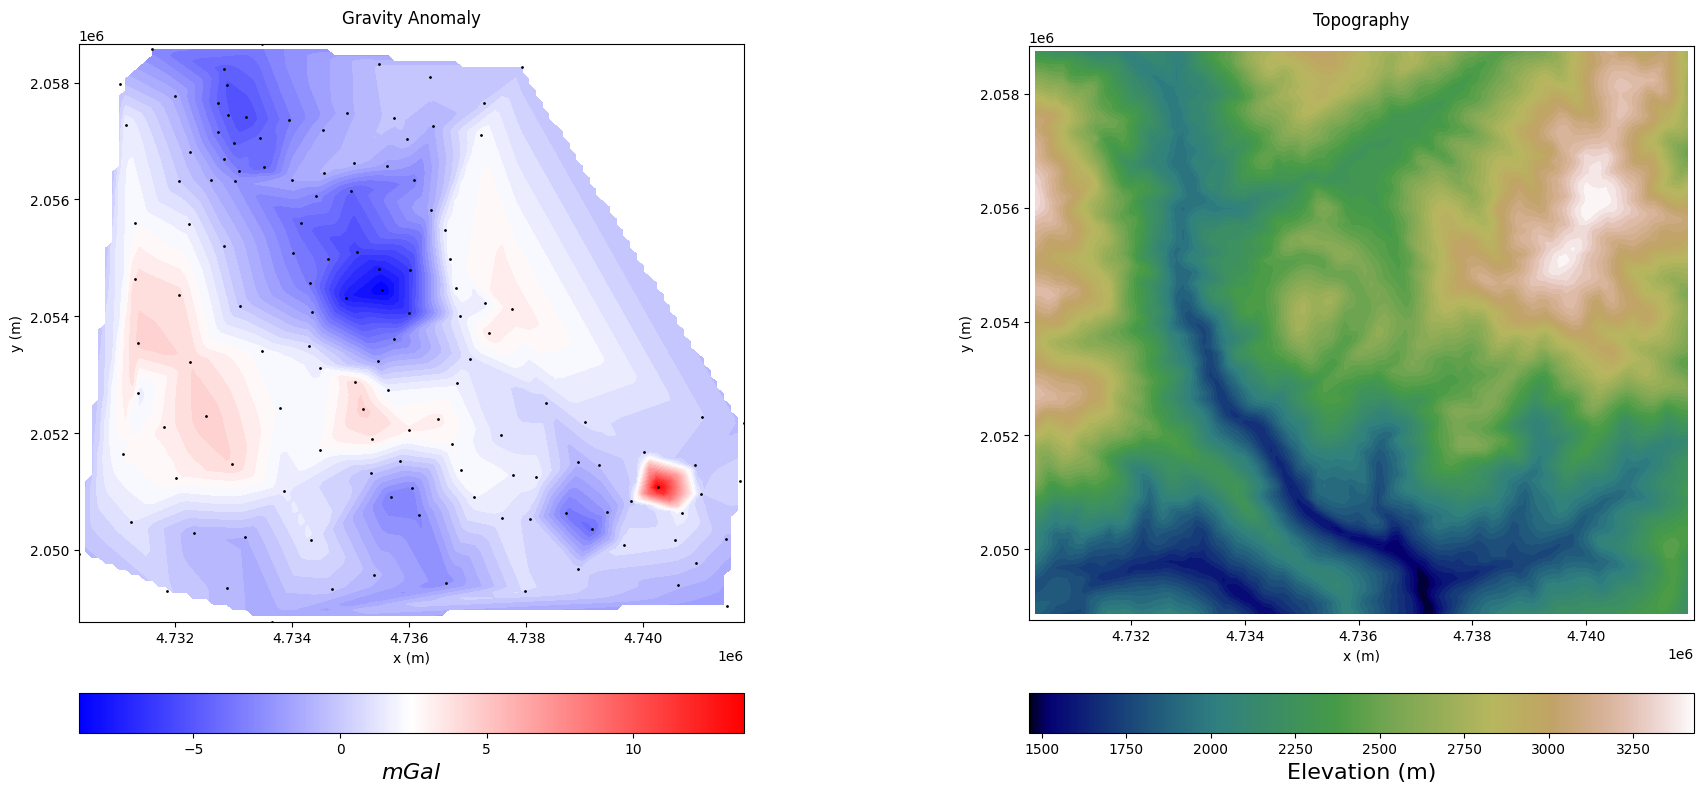

In [10]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt


# # Normalización de los datos de 'dobs' para el rango de -16 a 8
# norm = mpl.colors.Normalize(vmin=-9, vmax=-1)
# dobs_normalized = norm(dobs)  # Normalización de los datos
# dobs=dobs_normalized

# Crear la figura
fig = plt.figure(figsize=(19, 10))

# Primer gráfico: Anomalía de gravedad
ax1 = fig.add_axes([0.05, 0.35, 0.35, 0.6])

# Usar el método plot2Ddata() para plotear los datos
# Asumiendo que plot2Ddata es una función definida previamente
# Asegúrate de que esta función reciba correctamente los datos normalizados.
plot2Ddata(
    receiver_locations,
    dobs,  # Usamos los datos normalizados
    ax=ax1,
    dataloc=True,
    ncontour=40,
    contourOpts={"cmap": "bwr"},
)

ax1.set_title("Gravity Anomaly", pad=15)
ax1.set_xlabel("x (m)")
ax1.set_ylabel("y (m)")

# Barra de color para la primera figura
cx1 = fig.add_axes([0.05, 0.25, 0.35, 0.04])
norm1 = mpl.colors.Normalize(vmin=np.min(dobs), vmax=np.max(dobs))
# Usar la normalización para la barra de colores
cbar1 = mpl.colorbar.ColorbarBase(
    cx1, norm=norm1, orientation="horizontal", cmap=mpl.cm.bwr
)
cbar1.set_label("$mGal$", size=16)

# Segundo gráfico: Topografía
ax2 = fig.add_axes([0.55, 0.35, 0.35, 0.6])
plot2Ddata(
    xyz_topo[:, 0:2],  # Coordenadas X, Y de la topografía
    xyz_topo[:, -1],    # Altura de la topografía (Z)
    ax=ax2,
    ncontour=50,
    contourOpts={"cmap": "gist_earth"},
)

ax2.set_title("Topography", pad=15)
ax2.set_xlabel("x (m)")
ax2.set_ylabel("y (m)")

# Barra de color para la segunda figura
cx2 = fig.add_axes([0.55, 0.25, 0.35, 0.04])
norm2 = mpl.colors.Normalize(vmin=np.min(xyz_topo[:, -1]), vmax=np.max(xyz_topo[:, -1]))
cbar2 = mpl.colorbar.ColorbarBase(
    cx2, norm=norm2, orientation="horizontal", cmap=mpl.cm.gist_earth
)
cbar2.set_label("Elevation (m)", size=16)

# Mostrar el gráfico
plt.show()


In [11]:
#Definir desviación estandar de nuestros datos, en este caso, será de 1
maximum_anomaly = np.max(np.abs(dobs))
floor_uncertainty = 0.05 * maximum_anomaly
uncertainties = floor_uncertainty * np.ones(np.shape(dobs))
print("Floor uncertainty: {}".format(floor_uncertainty))

Floor uncertainty: 0.6885


In [12]:
rel_unc = 0.02          # 2% relative (tune: 0.01–0.03)
floor_unc = 0.05        # mGal floor (tune from reductions / repeatability)
sigma = floor_unc + rel_unc * np.abs(dobs)
print(f"Unc stats -> floor={floor_unc:.3f} mGal, rel={100*rel_unc:.1f}%, "
      f"median σ={np.median(sigma):.3f} mGal")

Unc stats -> floor=0.050 mGal, rel=2.0%, median σ=0.083 mGal


In [13]:
# Definir los receptores (con los puntos XYZ). Los datos consisten en mediciones de anomalías verticales de gravedad.
# El conjunto de receptores debe definirse como una lista.
receiver_list = gravity.receivers.Point(receiver_locations, components="gz")
receiver_list = [receiver_list]

# Definir el campo de la fuente
source_field = gravity.sources.SourceField(receiver_list=receiver_list)

# Define el survey (sondeo)
survey = gravity.survey.Survey(source_field)

In [14]:
#Definir los datos que serán invertidos
data_object = data.Data(survey, dobs=-dobs, standard_deviation=sigma)

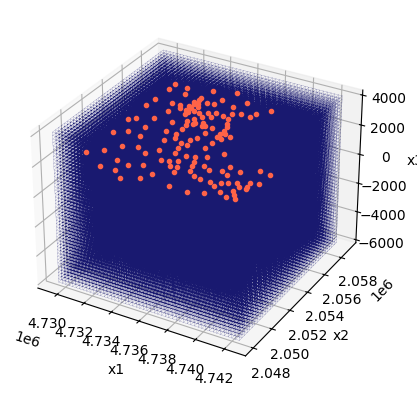

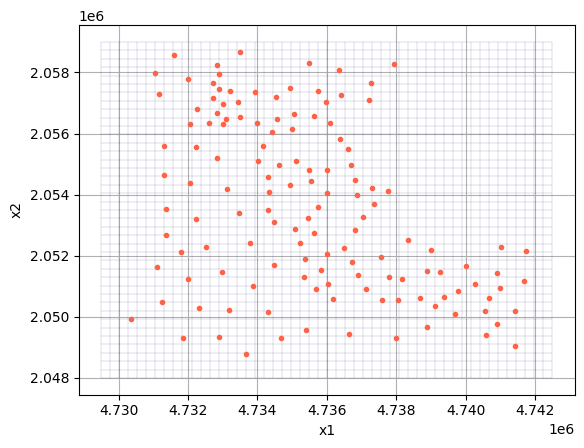

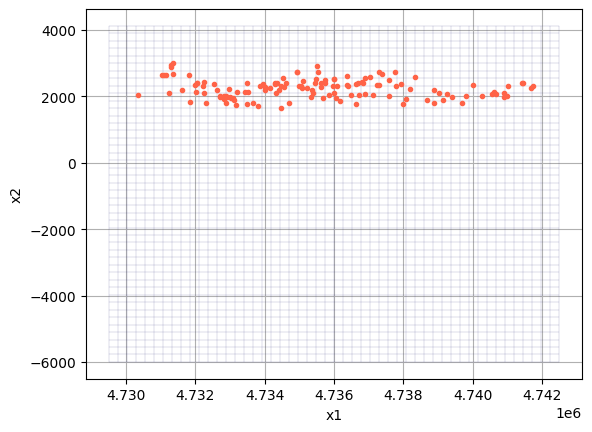

In [15]:
from discretize import TensorMesh
import matplotlib.pyplot as plt

# dx = 100 #55
# ncx = 130 #55
# dy = 100 #55
# ncy = 110 #73
# dz = 100 #55
# ncz = 100 #165


dx = 260 #55
ncx = 50 #55
dy = 275 #55
ncy = 40 #73
dz = 225 #55
ncz = 45 #165


hx = [(dx, ncx)]
hy = [(dy, ncy)]
hz = [(dz, ncz)]
mesh = TensorMesh([hx, hy, hz], x0=[4729500,2048000,-6000])
mesh.plot_grid(color="midnightblue", linewidth=0.1)
plt.plot(x, y, z, '.', color='tomato')

meshes = TensorMesh([hx, hy], x0=[4729500,2048000])
meshes.plot_grid(color="midnightblue", linewidth=0.1)
plt.plot(x, y, '.', color='tomato')

meshes1 = TensorMesh([hx, hz], x0=[4729500,-6000])
meshes1.plot_grid(color="midnightblue", linewidth=0.1)
plt.plot(x, z, '.', color='tomato')

In [16]:
# # import numpy as np
# from discretize import TreeMesh

# # Tamaños de celda mínimos
# dx = 100  # Cambiado de 50 a 100
# dy = 90  
# dz = 85  

# # Dimensiones del dominio
# x_length = 12000.0  # Largo en X
# y_length = 11000.0  # Largo en Y
# z_length = 8500.0  # Profundidad total (de -6000 a 4000)

# # Calcular número de celdas base (potencia de 2)
# nbcx = 2 ** int(np.round(np.log(x_length / dx) / np.log(2.0)))
# nbcy = 2 ** int(np.round(np.log(y_length / dy) / np.log(2.0)))
# nbcz = 2 ** int(np.round(np.log(z_length / dz) / np.log(2.0)))

# # Definir la malla base
# hx = [(dx, nbcx)]
# hy = [(dy, nbcy)]
# hz = [(dz, nbcz)]

# # Coordenadas de inicio
# x0 = [4729500,2048000,-6000]

# # Crear malla
# mesh = TreeMesh([hx, hy, hz], x0=x0)

# # Refinar superficie topográfica
# mesh.refine_surface(xyz_topo, padding_cells_by_level=[4, 4], finalize=False)

# # Refinar caja en zona de interés
# wsb_corner = np.array([4733500, 2053000, -3200])  # Esquina suroeste inferior
# ent_corner = np.array([4737500, 2056500, 2000])   # Esquina noreste superior

# # -1 significa usar el tamaño de celda más pequeño
# mesh.refine_box(wsb_corner, ent_corner, levels=[-1], finalize=False)

# # Finalizar la malla
# mesh.finalize()

# # Volúmenes de celda
# v = mesh.cell_volumes
# 4729500,2048000,-6000
# # Visualizar
# fig = plt.figure(figsize=(10, 8))
# ax = fig.add_subplot(111)
# mesh.plot_slice(
#     np.log10(v),
#     normal="y",
#     ax=ax,
#     slice_loc=2054372,  # Centro de la zona de interés en X
#     # slice_loc=4735500,
#     grid=False)
# ax.set_ylim(-6000, 5000)
# ax.set_title(f"Log10(Volumen) en X = 2054372 m")

# print(f"Celdas totales: {mesh.nC}")
# print(f"Volumen mínimo: {v.min():.1f} m³")

In [17]:
# Encuentra los índices de las celdas activas en el modelo de avance (las que están por debajo de la superficie)
active_tensor_cells = active_from_xyz(mesh, topografia)

# Definir la asignación del modelo a las celdas activas
n_tensor_active = int(active_tensor_cells.sum())

tensor_model_map = maps.IdentityMap(nP=n_tensor_active)

In [18]:
# starting_tensor_model = 1e-6 * np.ones(n_tensor_active)

In [19]:
starting_tensor_model = np.zeros(n_tensor_active)
active_cells_centers = mesh.cell_centers[active_tensor_cells]
z_active = active_cells_centers[:, 2]
z_normalized = (z_active - z_active.min()) / (z_active.max() - z_active.min())
starting_tensor_model = 0.3 - 0.6 * z_normalized

In [20]:
starting_tensor_model.shape

(74727,)

In [21]:
# Map for ignoring inactive cells when plotting
reference_tensor_model = np.zeros_like(starting_tensor_model)

In [22]:
# Orden para ignorar celdas inactivas al trazar las celdas totales del modelo
tensor_plotting_map = maps.InjectActiveCells(mesh, active_tensor_cells, np.nan)

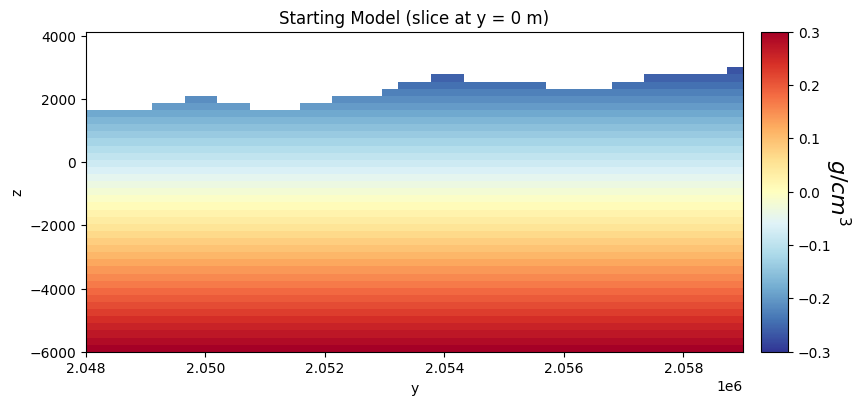

In [23]:
fig = plt.figure(figsize=(9, 4))
ax1 = fig.add_axes([0.1, 0.1, 0.73, 0.8])


norm = mpl.colors.Normalize(
    vmin=np.min(starting_tensor_model), vmax=np.max(starting_tensor_model))

mesh.plot_slice(
    tensor_plotting_map * starting_tensor_model,
    normal="x",
    ax=ax1,
    ind=int(mesh.shape_cells[1] / 2),
    grid=False,
    pcolor_opts={"cmap": mpl.cm.RdYlBu_r, "norm": norm},
)

ax1.set_title("Starting Model (slice at y = 0 m)")

ax2 = fig.add_axes([0.85, 0.1, 0.03, 0.8])
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.RdYlBu_r
)
cbar.set_label("$g/cm^3$", rotation=270, labelpad=15, size=16)

plt.show()

In [24]:
import vtk
models = {'Densidad':tensor_plotting_map*starting_tensor_model}
databse = mesh.to_vtk(models)
databse.save('modelo_de_iniciacion3_1.vtk')

In [25]:
#Definimos la física del problema de la gravedad utilizando la clase de simulación.
simulation_L2 = gravity.simulation.Simulation3DIntegral(
    survey=survey,
    mesh=mesh,
    rhoMap=tensor_model_map,
    ind_active=active_tensor_cells,
    engine="choclo",
    store_sensitivities="ram",
)

In [26]:
from simpeg import data_misfit
# Definir el desajuste de datos. Aquí el desajuste de datos es la norma L2 del residuo
# ponderado entre los datos observados y los datos predichos para un modelo dado.
# Dentro del desajuste de datos, el residuo entre los datos predichos y observados son
# normalizados por la desviación estándar de los datos.
dmis_L2 = data_misfit.L2DataMisfit(data=data_object, simulation=simulation_L2)
# dmis_L2.W = utils.sdiag(1 / uncertainties)

In [27]:
#Aplicar depth weighting
wr_Depth = utils.depth_weighting(
    mesh, receiver_locations, active_cells=active_tensor_cells, exponent=3, threshold=5, v=2
    )
wr_Depth = wr_Depth**2

In [28]:
# Definir la regularización (función objetivo del modelo).
reg_L2 = regularization.WeightedLeastSquares(
    mesh,
    active_cells=active_tensor_cells,
    mapping=tensor_model_map,
    alpha_s=1e-4,    # Smallness - reduce para permitir más anomalía
    alpha_x=1.0,     # Smoothness X
    alpha_y=1.0,     # Smoothness Y  
    alpha_z=10.0,     # De menor magnitud para permitir capas horizontales
    reference_model=reference_tensor_model,
    reference_model_in_smooth=True,
    weights={'cell_weights':wr_Depth}
)     


In [29]:
from simpeg.utils import depth_weighting

In [30]:
# wr_Depth = np.load('./cellWeights_Depth.npy')
# reg_L2.set_weights = wr_Depth


In [31]:
# Definir cómo se resuelve el problema de optimización. Aquí vamos a utilizar un enfoque
# Gauss-Newton proyectado que emplea el solucionador de gradiente conjugado.

opt_L2 = optimization.ProjectedGNCG(
    maxIter=20,
    maxIterLS=60,
    maxIterCG=70,
    tolCG=1e-3,
    lower=-0.4,   # Densidad mínima
    upper=0.5     # Pequeñas anomalías positivas permitidas
)

In [32]:
# Aquí definimos el problema inverso que hay que resolver
inv_prob_L2 = inverse_problem.BaseInvProblem(dmis_L2, reg_L2, opt_L2)

In [33]:
# Opciones para generar modelos recuperados y datos predichos para cada beta
save_iteration = directives.SaveOutputDictEveryIteration()
save_iteration.outDict = {}

# Añadir ponderaciones de sensibilidad
sensitivity_weights = directives.UpdateSensitivityWeights(every_iteration=True,
                                                          threshold_value=1e-12,
                                                          threshold_method='amplitude',
                                                          normalization_method='maximum')

# Actualizar el precondicionador si depende del modelo
update_jacobi = directives.UpdatePreconditioner(update_every_iteration=True) #Importante XDDDD
# Definir un valor inicial para el parámetro de compensación (beta) entre el desajuste de los datos y la regularización.
starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=1)
# Taza de diminución del valor de Beta
beta_schedule = directives.BetaSchedule(coolingFactor=2.0, coolingRate=1)

target_misfit = directives.TargetMisfit(chifact=1.0)


# Las directivas se definen como una lista
directives_list_L2 = [
    sensitivity_weights,
    update_jacobi,
    starting_beta,
    beta_schedule,
    target_misfit,
    save_iteration,
]

In [34]:
# Aquí combinamos el problema inverso y el conjunto de directivas
inv_L2 = inversion.BaseInversion(inv_prob_L2, directives_list_L2)

# Correr la inversión
recovered_tensor_model = inv_L2.run(starting_tensor_model)


Running inversion with SimPEG v0.24.0

                    simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using the default solver SolverLU and no solver_opts.***
                    


c:\Users\gabri\anaconda3\envs\volcan\lib\site-packages\pymatsolver\wrappers.py:81: SparseEfficiencyWarning: splu converted its input to CSC format
  self.solver = fun(self.A, **self.kwargs)


model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  2.35e+01  4.28e+05  6.02e+01  4.30e+05    1.32e+02      0              
   1  1.17e+01  3.60e+03  8.41e+00  3.70e+03    1.05e+02      0              
   2  5.87e+00  1.60e+03  7.59e+00  1.64e+03    1.42e+02      0   Skip BFGS  
   3  2.94e+00  1.42e+03  7.81e+00  1.44e+03    1.41e+02      1   Skip BFGS  
   4  1.47e+00  8.74e+02  8.80e+00  8.87e+02    1.12e+02      2              
   5  7.34e-01  8.74e+02  8.80e+00  8.80e+02    1.12e+02     10   Skip BFGS  
   6  3.67e-01  7.72e+02  9.45e+00  7.75e+02    1.27e+02      3              
   7  1.83e-01  5.91e+02  3.26e+01  5.97e+02    1.38e+02      0   Skip BFGS  
   8  9.17e-02  5.87e+02  3.62e+01  5.90e+02    1.14e+02      2              
   9  4.59e-02  5.86e+02

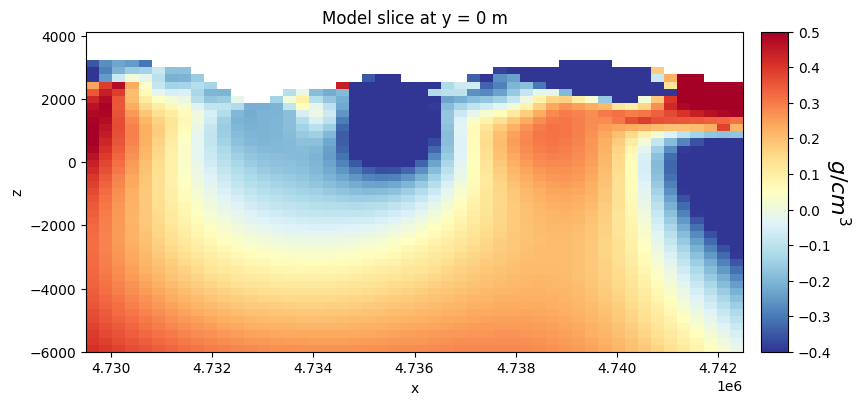

In [35]:
# Ploter el modelo recuperado
fig = plt.figure(figsize=(9, 4))
ax1 = fig.add_axes([0.1, 0.1, 0.73, 0.8])


norm = mpl.colors.Normalize(
    vmin=np.min(recovered_tensor_model), vmax=np.max(recovered_tensor_model)
    )

# norm = mpl.colors.Normalize(vmin=-0.3, vmax=0.3)


mesh.plot_slice(
    tensor_plotting_map * recovered_tensor_model,
    normal="y",
    ax=ax1,
    slice_loc=2054572,
    grid=False,
    pcolor_opts={"cmap": mpl.cm.RdYlBu_r, "norm": norm},
)
ax1.set_title("Model slice at y = 0 m")

ax2 = fig.add_axes([0.85, 0.1, 0.03, 0.8])
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.RdYlBu_r
)
cbar.set_label("$g/cm^3$", rotation=270, labelpad=15, size=16)

plt.show()


In [36]:
import vtk
models = {'Densidad':tensor_plotting_map*recovered_tensor_model}
databse = mesh.to_vtk(models)
databse.save('modelo_3_1.vtk')

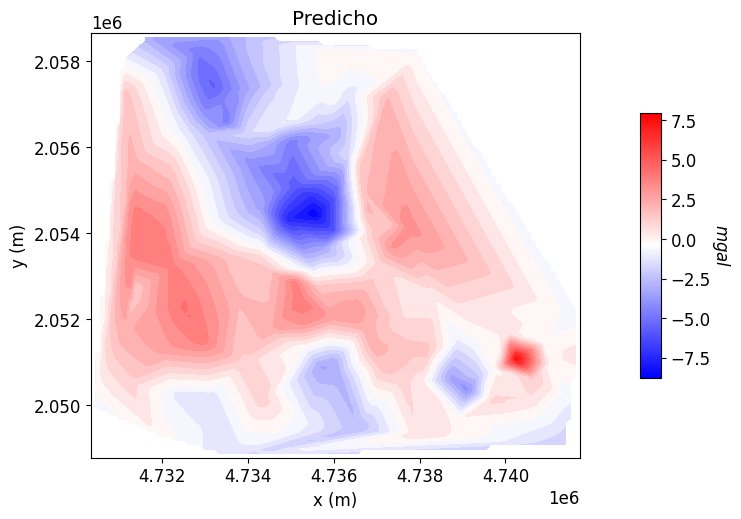

7.969092

In [37]:
#Plotear el valor predicho
dpred = (-inv_prob_L2.dpred)

# Plot
mpl.rcParams.update({"font.size": 12})
fig = plt.figure(figsize=(7, 5))

v_lim = [np.min(dpred), np.max(dpred)]

ax1 = fig.add_axes([0.1, 0.1, 0.73, 0.85])
plot2Ddata(
    receiver_list[0].locations,
    dpred,
    ax=ax1,
    ncontour=30,
    clim=[np.min(dpred), np.max(dpred)],
    contourOpts={"cmap": "bwr"})
ax1.set_title("Predicho")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("y (m)")

ax2 = fig.add_axes([0.9, 0.26, 0.03, 0.53])
norm = mpl.colors.Normalize(vmin=np.min(dpred), vmax=np.max(dpred))
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.bwr,
)
cbar.set_label("$mgal$", rotation=270, labelpad=15, size=12)

plt.show()
np.max(dpred)

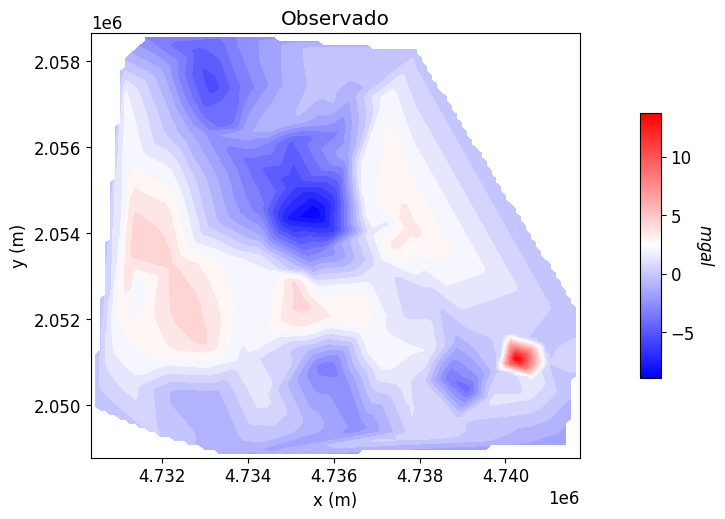

In [38]:
#Plotear el valor observado
mpl.rcParams.update({"font.size": 12})
fig = plt.figure(figsize=(7, 5))

ax1 = fig.add_axes([0.1, 0.1, 0.73, 0.85])
plot2Ddata(receiver_locations, dobs, ax=ax1, ncontour=30, contourOpts={"cmap": "bwr"})
ax1.set_title("Observado")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("y (m)")

ax2 = fig.add_axes([0.9, 0.26, 0.03, 0.53])
norm = mpl.colors.Normalize(vmin=-np.max(-dobs), vmax=np.max(dobs))
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.bwr,
)
cbar.set_label("$mgal$", rotation=270, labelpad=15, size=12)

plt.show()

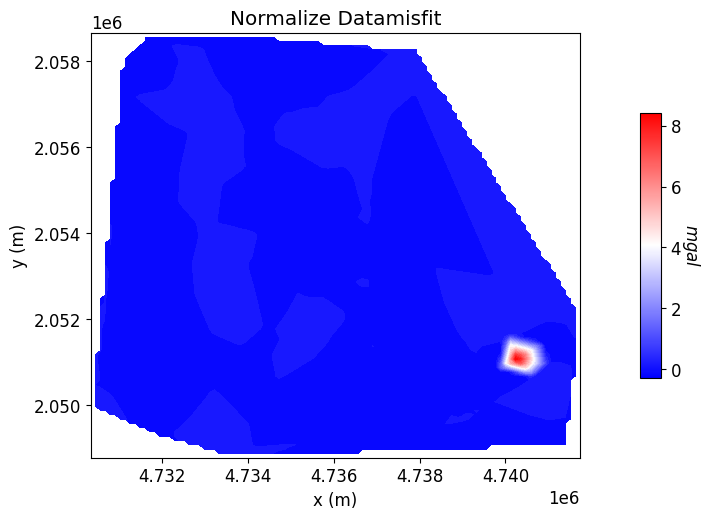

In [39]:
data_misfit= (dobs - dpred) / uncertainties


mpl.rcParams.update({"font.size": 12})
fig = plt.figure(figsize=(7, 5))

ax1 = fig.add_axes([0.1, 0.1, 0.73, 0.85])
plot2Ddata(receiver_locations,
           data_misfit,
           ax=ax1,
           ncontour=30,
           contourOpts={"cmap": "bwr"})
ax1.set_title("Normalize Datamisfit")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("y (m)")

ax2 = fig.add_axes([0.9, 0.26, 0.03, 0.53])
norm = mpl.colors.Normalize(vmin=-np.max(-data_misfit), vmax=np.max(data_misfit))
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.bwr,
)
cbar.set_label("$mgal$", rotation=270, labelpad=15, size=12)

plt.show()

In [40]:
# Compute normalized data misfits
normalized_data_misfits = (dobs - dpred) / sigma


In [41]:
def plot_tikhonov_curve(iteration, scale):
    phi_d = []
    phi_m = []
    beta = []
    iterations = np.arange(len(save_iteration.outDict)) + 1
    for kk in iterations:
        phi_d.append(save_iteration.outDict[kk]['phi_d'])
        phi_m.append(save_iteration.outDict[kk]['phi_m'])
        beta.append(save_iteration.outDict[kk]['beta'])
    fig, axs = plt.subplots(1, 2, figsize=(12,5))
    axs[0].plot(phi_m ,phi_d, 'k.-')
    axs[0].plot(phi_m[iteration-1] ,phi_d[iteration-1], 'go', ms=10)
    axs[0].set_xlabel("$\phi_m$")
    axs[0].set_ylabel("$\phi_d$")
    axs[0].grid(True)

    axs[1].plot(iterations, phi_d, 'k.-')
    axs[1].plot(iterations[iteration-1], phi_d[iteration-1], 'go', ms=10)
    ax_1 = axs[1].twinx()
    ax_1.plot(iterations, phi_m, 'r.-')
    ax_1.plot(iterations[iteration-1], phi_m[iteration-1], 'go', ms=10)
    axs[1].set_ylabel("$\phi_d$")
    ax_1.set_ylabel("$\phi_m$")
    axs[1].set_xlabel("Iterations")
    axs[1].grid(True)
    axs[0].set_title(
        "$\phi_d$={:.1e}, $\phi_m$={:.1e}, $\\beta$={:.1e}".format(phi_d[iteration-1], phi_m[iteration-1], beta[iteration-1]),
        fontsize = 14
    )
    axs[1].set_title("Target misfit={:.0f}".format(survey.nD/2))
    for ii, ax in enumerate(axs):
        if ii == 0:
            ax.set_xscale(scale)
        ax.set_yscale(scale)
        xlim = ax.get_xlim()
        ax.hlines(survey.nD/2, xlim[0], xlim[1], linestyle='--', label='$\phi_d^{*}$')
        ax.set_xlim(xlim)
    axs[0].legend()

    plt.tight_layout()

In [42]:
for valor in normalized_data_misfits:
    print(valor)

0.14733754779736885
17.827007092063823
0.06588581023905951
0.16699881856656806
0.1324559601259928
0.11305957027131473
0.09007485165977297
0.2038450919434636
0.1659721189598221
0.1369177156193257
0.10750070847465641
0.04493683730999914
0.20043220032345138
-0.33179918924967444
-0.18983948720644475
-0.002261570521761542
-0.0348357087007932
0.02609053671648079
0.11456160895568453
0.10856930904976884
0.08484553364874114
-0.006941386631556919
-0.1794348695796904
-0.025644104636646962
-0.07489145964300953
-0.043266210983047296
-0.10511221424225693
-0.1186827481803255
-0.10135851341022586
-0.02146297030978609
-0.15114718589229795
-0.0809436383312693
0.07044676153417588
-0.07475051614973402
0.1354833733583671
-0.05352875155865891
-0.28590097239143025
-0.03949997672898004
0.021919608116149902
-0.07620524334651263
-0.34233248511026054
-0.15281021870523295
-0.09881409030718992
-0.10245698932917341
-0.10821053794786047
-0.14001986401229205
-1.2004787937747285
-0.7247246996894564
0.8082746449163403


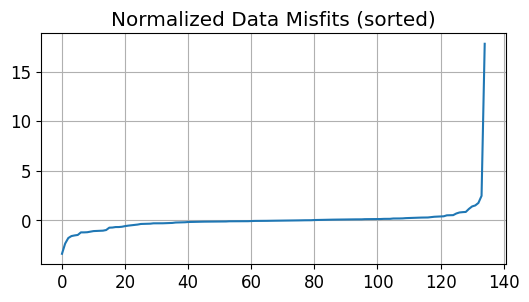

In [43]:
# Plot the normalized data misfits
fig = plt.figure(figsize=(6, 3))
ax = fig.add_subplot(111)
ax.plot(np.sort(normalized_data_misfits))
ax.set_title("Normalized Data Misfits (sorted)")
ax.grid()
plt.show(fig)

In [44]:
for valor in sigma:
    print(valor)

0.0678
0.32539999999999997
0.1618
0.1196
0.14200000000000002
0.1482
0.1526
0.09559999999999999
0.1114
0.1256
0.1412
0.0772
0.0704
0.12000000000000001
0.1168
0.13440000000000002
0.11080000000000001
0.0828
0.1416
0.1362
0.1442
0.07
0.1002
0.1254
0.0718
0.134
0.12400000000000001
0.11800000000000001
0.0746
0.07200000000000001
0.069
0.0584
0.0748
0.07200000000000001
0.06860000000000001
0.0782
0.06080000000000001
0.1116
0.08
0.093
0.12040000000000001
0.12980000000000003
0.0742
0.09340000000000001
0.051000000000000004
0.1062
0.060200000000000004
0.07640000000000001
0.059000000000000004
0.0516
0.08960000000000001
0.0524
0.057800000000000004
0.1164
0.08360000000000001
0.1194
0.0902
0.07400000000000001
0.09240000000000001
0.0882
0.0862
0.055
0.0538
0.20140000000000002
0.22820000000000001
0.0748
0.1126
0.1116
0.0666
0.079
0.093
0.082
0.06820000000000001
0.0548
0.115
0.0868
0.0796
0.1412
0.12440000000000001
0.137
0.1738
0.06280000000000001
0.09240000000000001
0.1366
0.16599999999999998
0.199
0.173

In [45]:
# Generate new data object
new_data_object = data.Data(survey, dobs=-dobs, standard_deviation=sigma)


In [46]:
# # #definir la malla
# # dx = 35
# # ncx = 55
# # dy = 37
# # ncy = 25
# # dz = 100
# # ncz = 80
# # dpadh = 4.5
# # exp_h = 1.5

# # hx = [(37, dpadh, -exp_h), (dx, ncx), (37, dpadh, exp_h)]
# # hy = [(20, dpadh, -exp_h), (dy, ncy), (20, dpadh, exp_h)]
# # hz = [(74, dpadh, -exp_h), (dz, ncz), (74, dpadh, exp_h)]
# # tree_mesh = TensorMesh([hx, hy, hz], x0=[853114,987543,-6000])
# # tree_mesh.plot_grid(color="midnightblue", linewidth=0.1)


# #definir la malla
# dx = 120
# ncx = 45
# dy = 125
# ncy = 50
# dz = 100
# ncz = 80
# dpadh = 4.5
# exp_h = 1.5

# hx = [(37, dpadh, -exp_h), (dx, ncx), (37, dpadh, exp_h)]
# hy = [(20, dpadh, -exp_h), (dy, ncy), (20, dpadh, exp_h)]
# hz = [(74, dpadh, -exp_h), (dz, ncz), (74, dpadh, exp_h)]
# tree_mesh = TensorMesh([hx, hy, hz], x0=[850500,983500,-6000])
# tree_mesh.plot_grid(color="midnightblue", linewidth=0.1)

# # # Valores con la mitad del detalle (celdas el doble de grandes, mitad de cantidad)
# # dx = 20  # 10 × 2
# # ncx = 95  # 280 ÷ 4
# # dy = 20  # 6 × 2
# # ncy = 68  # 111 ÷ 2 (redondeado)
# # dz = 62  # 20 × 2
# # ncz = 113  # 350 ÷ 2
# # dpadh = 4.7  # Se mantiene igual
# # exp_h = 1.7  # Se mantiene igual

# # hx = [(30, dpadh, -exp_h), (dx, ncx), (30, dpadh, exp_h)]
# # hy = [(20, dpadh, -exp_h), (dy, ncy), (20, dpadh, exp_h)]
# # hz = [(104, dpadh, -exp_h), (dz, ncz), (104, dpadh, exp_h)]
# # tree_mesh = TensorMesh([hx, hy, hz], x0=[853114,987043,-6500])
# # tree_mesh.plot_grid(color="midnightblue", linewidth=0.1)


# # # Valores con la mitad del detalle (celdas el doble de grandes, mitad de cantidad)
# # dx = 10  # 5 × 2
# # ncx = 140  # 280 ÷ 2
# # dy = 12  # 6 × 2
# # ncy = 55  # 111 ÷ 2 (redondeado)
# # dz = 40  # 20 × 2
# # ncz = 175  # 350 ÷ 2
# # dpadh = 4.7  # Se mantiene igual
# # exp_h = 1.7  # Se mantiene igual

# # # Definir la malla con los valores ajustados
# # hx = [(50, dpadh, -exp_h), (dx, ncx), (50, dpadh, exp_h)]
# # hy = [(40, dpadh, -exp_h), (dy, ncy), (40, dpadh, exp_h)]
# # hz = [(104, dpadh, -exp_h), (dz, ncz), (104, dpadh, exp_h)]
# # meshes = TensorMesh([hx, hy, hz], x0=[853614, 987543, -6000])
# # tree_mesh = TensorMesh([hx, hy, hz], x0=[853114,987043,-6500])
# # tree_mesh.plot_grid(color="midnightblue", linewidth=0.1)

# plt.plot(x, y, z, '.', color='tomato')

In [47]:
# import numpy as np
# from discretize import TreeMesh

# # Tamaños de celda mínimos
# dx = 100  # Cambiado de 50 a 100
# dy = 90  
# dz = 85  

# # Dimensiones del dominio
# x_length = 12000.0  # Largo en X
# y_length = 11000.0  # Largo en Y
# z_length = 8500.0  # Profundidad total (de -6000 a 4000)

# # Calcular número de celdas base (potencia de 2)
# nbcx = 2 ** int(np.round(np.log(x_length / dx) / np.log(2.0)))
# nbcy = 2 ** int(np.round(np.log(y_length / dy) / np.log(2.0)))
# nbcz = 2 ** int(np.round(np.log(z_length / dz) / np.log(2.0)))

# # Definir la malla base
# hx = [(dx, nbcx)]
# hy = [(dy, nbcy)]
# hz = [(dz, nbcz)]

# # Coordenadas de inicio
# x0 = [4729500,2048000,-6000]

# # Crear malla
# tree_mesh = TreeMesh([hx, hy, hz], x0=x0)

# # Refinar superficie topográfica
# tree_mesh.refine_surface(xyz_topo, padding_cells_by_level=[4, 4], finalize=False)

# # Refinar caja en zona de interés
# wsb_corner = np.array([4733500, 2053000, -3200])  # Esquina suroeste inferior
# ent_corner = np.array([4737500, 2056500, 2000])   # Esquina noreste superior

# # -1 significa usar el tamaño de celda más pequeño
# tree_mesh.refine_box(wsb_corner, ent_corner, levels=[-1], finalize=False)

# # Finalizar la malla
# tree_mesh.finalize()

# # Volúmenes de celda
# v = tree_mesh.cell_volumes
# 4729500,2048000,-6000
# # Visualizar
# fig = plt.figure(figsize=(10, 8))
# ax = fig.add_subplot(111)
# tree_mesh.plot_slice(
#     np.log10(v),
#     normal="x",
#     ax=ax,
#     # slice_loc=2054372,  # Centro de la zona de interés en X
#     slice_loc=4735500,
#     grid=False)
# ax.set_ylim(-6000, 5000)
# ax.set_title(f"Log10(Volumen) en X = 2054372 m")

# print(f"Celdas totales: {tree_mesh.nC}")
# print(f"Volumen mínimo: {v.min():.1f} m³")

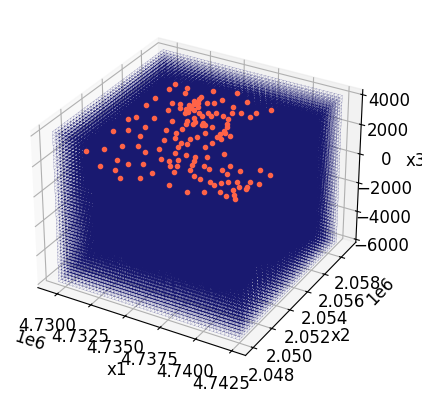

In [48]:
# dx = 100 #55
# ncx = 130 #55
# dy = 100 #55
# ncy = 110 #73
# dz = 100 #55
# ncz = 100 #165


dx = 260 #55
ncx = 50 #55
dy = 275 #55
ncy = 40 #73
dz = 225 #55
ncz = 45 #165


hx = [(dx, ncx)]
hy = [(dy, ncy)]
hz = [(dz, ncz)]
tree_mesh = TensorMesh([hx, hy, hz], x0=[4729500,2048000,-6000])
tree_mesh.plot_grid(color="midnightblue", linewidth=0.1)

plt.plot(x, y, z, '.', color='tomato')

In [49]:
active_tree_cells = active_from_xyz(tree_mesh, topografia)
n_tree_active = int(active_tree_cells.sum())

In [50]:
tree_model_map = maps.IdentityMap(nP=n_tree_active)

In [51]:
starting_tree_model = 1e-6 * np.ones(n_tree_active)

In [52]:
# starting_tree_model = recovered_tensor_model.copy()

# # starting_tensor_model

# ind_sphere = model_builder.get_indices_sphere(
#     np.r_[4735320, 2054777, -1700], 1000.0, tree_mesh.gridCC
# )
# ind_sphere = ind_sphere[active_tree_cells]
# starting_tree_model[ind_sphere] = -0.3

In [53]:

reference_tree_model = np.zeros_like(starting_tree_model)

In [54]:
tree_plotting_map = maps.InjectActiveCells(tree_mesh, active_tree_cells, np.nan)

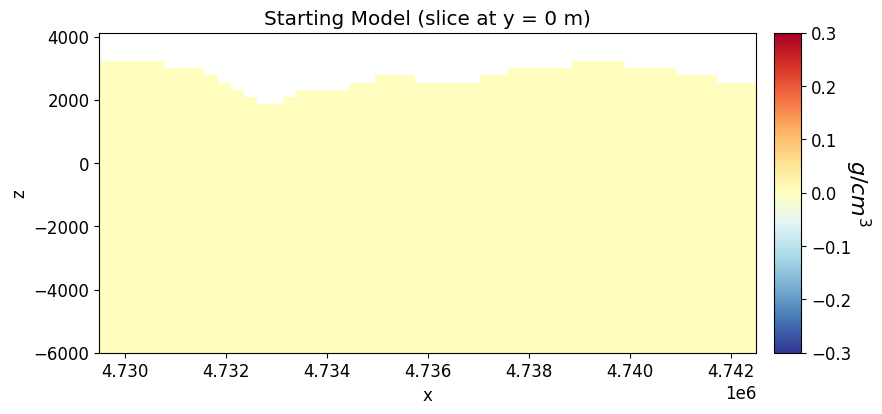

In [55]:
fig = plt.figure(figsize=(9, 4))
ax1 = fig.add_axes([0.1, 0.1, 0.73, 0.8])


norm = mpl.colors.Normalize(
    vmin=np.min(starting_tensor_model), vmax=np.max(starting_tensor_model))


norm = mpl.colors.Normalize(vmin=-0.3, vmax=0.3)


mesh.plot_slice(
    tree_plotting_map * starting_tree_model,
    normal="y",
    ax=ax1,
    slice_loc=2054572,
    grid=False,
    pcolor_opts={"cmap": mpl.cm.RdYlBu_r, "norm": norm},
)

ax1.set_title("Starting Model (slice at y = 0 m)")

ax2 = fig.add_axes([0.85, 0.1, 0.03, 0.8])
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.RdYlBu_r
)
cbar.set_label("$g/cm^3$", rotation=270, labelpad=15, size=16)

# Ensure the folder exists
output_folder = "figuras_modelo_inicial"
os.makedirs(output_folder, exist_ok=True)

# Save the figure in the folder
plt.savefig(os.path.join(output_folder, 'esfera_1700.svg'), dpi=500)

plt.show()

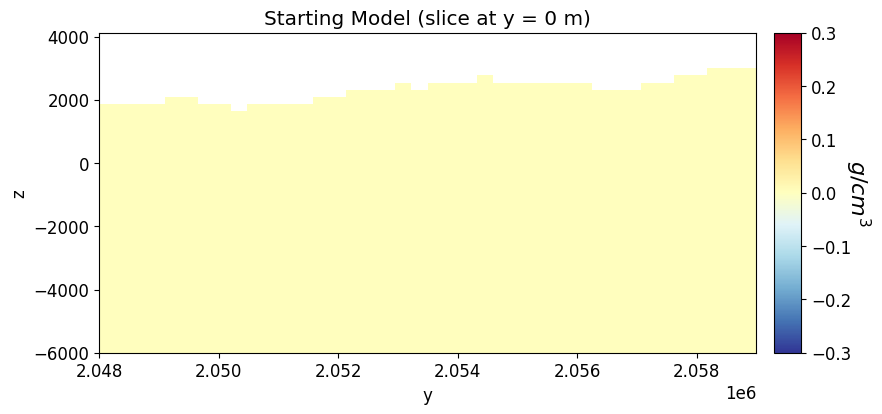

In [56]:
fig = plt.figure(figsize=(9, 4))
ax1 = fig.add_axes([0.1, 0.1, 0.73, 0.8])


norm = mpl.colors.Normalize(
    vmin=np.min(starting_tensor_model), vmax=np.max(starting_tensor_model))


norm = mpl.colors.Normalize(vmin=-0.3, vmax=0.3)


mesh.plot_slice(
    tree_plotting_map * starting_tree_model,
    normal="x",
    ax=ax1,
    slice_loc=4735700,
    grid=False,
    pcolor_opts={"cmap": mpl.cm.RdYlBu_r, "norm": norm},
)

ax1.set_title("Starting Model (slice at y = 0 m)")

ax2 = fig.add_axes([0.85, 0.1, 0.03, 0.8])
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.RdYlBu_r
)
cbar.set_label("$g/cm^3$", rotation=270, labelpad=15, size=16)

# Ensure the folder exists
output_folder = "figuras_modelo_inicial"
os.makedirs(output_folder, exist_ok=True)

# Save the figure in the folder
plt.savefig(os.path.join(output_folder, 'esfera_1700_2.svg'), dpi=500)

plt.show()

In [57]:
models = {'Densidad':tree_plotting_map*starting_tree_model}
databse = mesh.to_vtk(models)
databse.save('modelo_start_1_2.vtk')

In [58]:
simulation_irls = gravity.simulation.Simulation3DIntegral(
    survey=survey,
    mesh=tree_mesh,
    rhoMap=tree_model_map,
    ind_active=active_tree_cells,
    engine="choclo",
    store_sensitivities="ram",
    )

In [59]:
from simpeg import data_misfit

dmis_irls = data_misfit.L2DataMisfit(data=new_data_object, simulation=simulation_irls)


In [60]:
wr_Depth = utils.depth_weighting(
    mesh, receiver_locations, active_cells=active_tensor_cells, exponent=2, threshold=np.min(hx)/4, v=2
    )
wr_Depth = wr_Depth**2

In [61]:
# wr_Depth = utils.depth_weighting(
#     tree_mesh, receiver_locations, active_cells=active_tree_cells, v=3, z0=3, #exponent=3, threshold=2
# )

In [62]:
# from simpeg.utils import distance_weighting
# distance_Weights = utils.distance_weighting(
#     mesh, receiver_locations, active_cells=active_tensor_cells, exponent=2, #threshold=2,# engine='scipy'#, cdist_opts={'metric': 'euclidean'}
# )

In [63]:
reg_irls = regularization.Sparse(
    tree_mesh,
    active_cells=active_tree_cells,
    alpha_s=1e-5,
    # alpha_s=0.0,
    alpha_x=1.0,
    alpha_y=1.0,
    alpha_z=1.0,
    # reference_model=reference_tree_model,
    # reference_model=1e-6 * np.ones(n_tree_active),    
    reference_model=np.zeros(n_tree_active),
    reference_model_in_smooth=False,
    norms=[2,1,1,1],
    weights={'cell_weights':wr_Depth,
            #  'gradients_weights':distance_Weights
             }
)

In [64]:
opt_irls = optimization.ProjectedGNCG(
    maxIter=20, lower=-0.3, upper=0.4, maxIterLS=60, maxIterCG=50, tolCG=1e-4, #LSshorten=0.2
)

In [65]:
inv_prob_irls = inverse_problem.BaseInvProblem(dmis_irls, reg_irls, opt_irls)

In [66]:
from simpeg import directives

save_iteration_new = directives.SaveOutputDictEveryIteration()
save_iteration_new.outDict = {}

sensitivity_weights_irls = directives.UpdateSensitivityWeights(every_iteration=True,
                                                               threshold_value=1e-10,
                                                               threshold_method='amplitude',
                                                               normalization_method='maximum',)
starting_beta_irls = directives.BetaEstimate_ByEig(beta0_ratio=1e-4)
beta_schedule_irls = directives.BetaSchedule(coolingFactor=2, coolingRate=1)
update_jacobi_irls = directives.UpdatePreconditioner(update_every_iteration=True)

update_irls = directives.Update_IRLS(
    coolingFactor=2.0,
    coolingRate=2.0,
    chifact_start=1.0,
    f_min_change=1e-4,
    max_irls_iterations=30,
    beta_tol=1e-2,
)

tarjet_misfit= directives.TargetMisfit(chifact=1.0)

directives_list_irls = [
    update_irls,
    sensitivity_weights_irls,
    starting_beta_irls,
    beta_schedule_irls,
    update_jacobi_irls,
    tarjet_misfit,
    save_iteration_new
]



C:\Users\gabri\AppData\Local\Temp\ipykernel_37720\1287868676.py:14: DeprecationWarning: Update_IRLS has been deprecated, please use InversionDirective. It will be removed in version 0.24.0 of SimPEG.
  update_irls = directives.Update_IRLS(


In [67]:
inv_irls = inversion.BaseInversion(inv_prob_irls, directives_list_irls)
recovered_tree_model = inv_irls.run(starting_tree_model)


Running inversion with SimPEG v0.24.0

                    simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using the default solver SolverLU and no solver_opts.***
                    


c:\Users\gabri\anaconda3\envs\volcan\lib\site-packages\pymatsolver\wrappers.py:81: SparseEfficiencyWarning: splu converted its input to CSC format
  self.solver = fun(self.A, **self.kwargs)


model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  2.00e-02  6.76e+04  5.09e-10  6.76e+04    8.97e+01      0              
   1  1.00e-02  3.79e+03  4.55e+01  3.79e+03    1.11e+02      0              
   2  2.50e-03  2.21e+03  7.03e+01  2.21e+03    9.77e+01      0   Skip BFGS  
   3  1.25e-03  1.12e+03  8.29e+01  1.12e+03    8.50e+01      0   Skip BFGS  
   4  3.13e-04  9.82e+02  8.72e+01  9.82e+02    8.51e+01      2              
   5  1.57e-04  7.69e+02  8.84e+01  7.69e+02    8.98e+01      3   Skip BFGS  
   6  3.91e-05  7.68e+02  9.08e+01  7.68e+02    1.11e+02      2   Skip BFGS  
   7  1.96e-05  7.49e+02  9.37e+01  7.49e+02    8.14e+01      3              
   8  4.89e-06  7.49e+02  9.37e+01  7.49e+02    8.14e+01     12   Skip BFGS  
   9  2.45e-06  7.20e+02

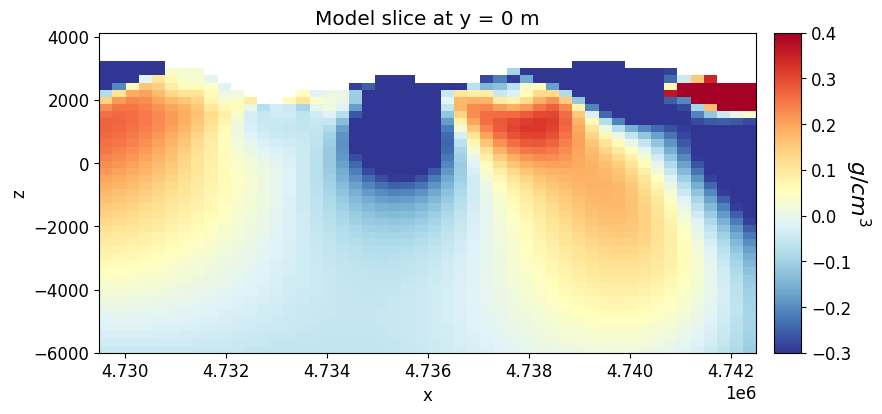

In [68]:
# Plot Recovered Model
fig = plt.figure(figsize=(9, 4))
ax1 = fig.add_axes([0.1, 0.1, 0.73, 0.8])

norm = mpl.colors.Normalize(
    vmin=np.min(recovered_tree_model), vmax=np.max(recovered_tree_model)
    )

# norm = mpl.colors.Normalize(vmin=-0.3, vmax=0.0)

tree_mesh.plot_slice(
    tree_plotting_map * recovered_tree_model,
    normal="y",
    ax=ax1,
    slice_loc=2054372,
    grid=False,
    pcolor_opts={"cmap": mpl.cm.RdYlBu_r, "norm": norm},
)


ax1.set_title("Model slice at y = 0 m")

ax2 = fig.add_axes([0.85, 0.1, 0.03, 0.8])
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.RdYlBu_r
)
cbar.set_label("$g/cm^3$", rotation=270, labelpad=15, size=16)

# # Ensure the folder exists
# output_folder = "p_values"
# os.makedirs(output_folder, exist_ok=True)

# # Save the figure in the folder
# plt.savefig(os.path.join(output_folder, 'y_inicial_0,2,2,2_maxIter=20_alpha=1e-4_beta=1e-4_LSshorten=None.svg'), dpi=500)

plt.show()

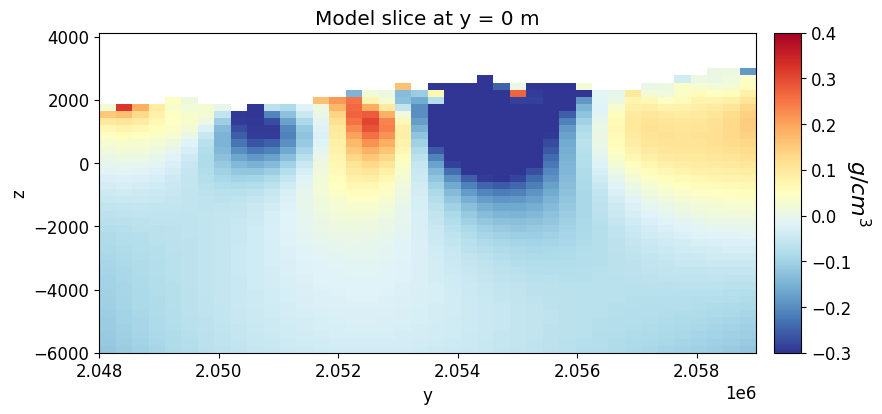

In [69]:
# Plot Recovered Model
fig = plt.figure(figsize=(9, 4))
ax1 = fig.add_axes([0.1, 0.1, 0.73, 0.8])

norm = mpl.colors.Normalize(
    vmin=np.min(recovered_tree_model), vmax=np.max(recovered_tree_model)
    )

# norm = mpl.colors.Normalize(vmin=-0.3, vmax=0.0)

tree_mesh.plot_slice(
    tree_plotting_map * recovered_tree_model,
    normal="x",
    ax=ax1,
    slice_loc=4735700,
    grid=False,
    pcolor_opts={"cmap": mpl.cm.RdYlBu_r, "norm": norm},
)


ax1.set_title("Model slice at y = 0 m")

ax2 = fig.add_axes([0.85, 0.1, 0.03, 0.8])
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.RdYlBu_r
)
cbar.set_label("$g/cm^3$", rotation=270, labelpad=15, size=16)

# # Ensure the folder exists
# output_folder = "figuras_2"
# os.makedirs(output_folder, exist_ok=True)

# # Save the figure in the folde
# plt.savefig(os.path.join(output_folder, 'x_inicial_maxIter=20_alpha=1e-5_beta=1e-4_LSshorten=None.svg'), dpi=500)

plt.show()

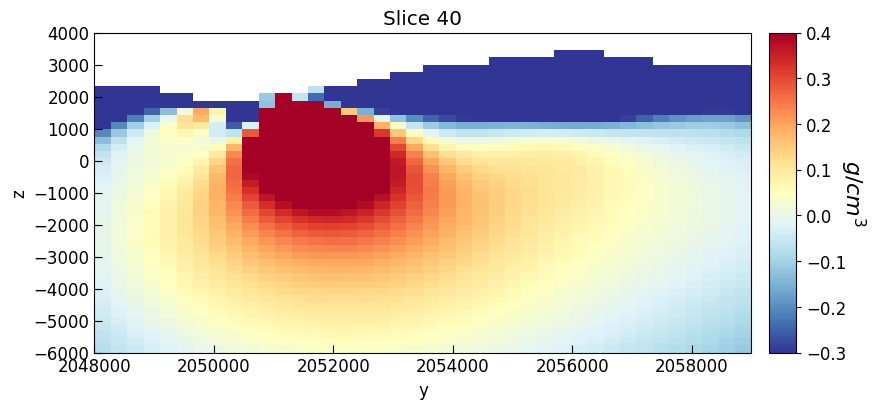

In [70]:
# Plot Recovered Model
fig = plt.figure(figsize=(9, 4))
ax1 = fig.add_axes([0.1, 0.1, 0.73, 0.8])

norm = mpl.colors.Normalize(
    vmin=np.min(recovered_tree_model), vmax=np.max(recovered_tree_model)
    )

# norm = mpl.colors.Normalize(vmin=-0.3, vmax=0.4)

tree_mesh.plot_slice(
    tree_plotting_map * recovered_tree_model,
    normal="x",
    ax=ax1,
    slice_loc=4740000,
    grid=False,
    pcolor_opts={"cmap": mpl.cm.RdYlBu_r, "norm": norm},
)

ax1.tick_params(axis='both', direction='in', length=6)
ax1.ticklabel_format(style='plain', axis='both')
# Para más marcas
ax1.locator_params(axis='y', nbins=10)
ax1.locator_params(axis='x', nbins=8)
ax1.set_ylim(-6000, 4000)

ax2 = fig.add_axes([0.85, 0.1, 0.03, 0.8])
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.RdYlBu_r
)
cbar.set_label("$g/cm^3$", rotation=270, labelpad=15, size=16)

# Ensure the folder exists
output_folder = "figuras_2"
os.makedirs(output_folder, exist_ok=True)

# Save the figure in the folder
plt.savefig(os.path.join(output_folder, 'x4740000_inicial_maxIter=20_alpha=1e-5_beta=1.0Sshorten=None.svg'), dpi=500)

plt.show()

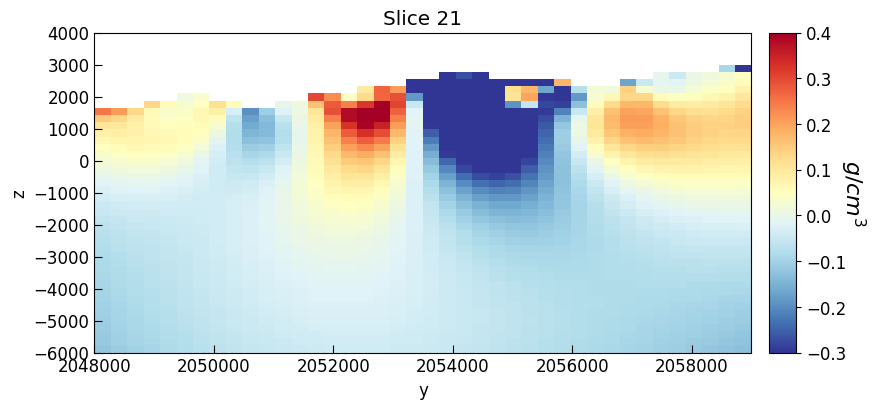

In [71]:
# Plot Recovered Model
fig = plt.figure(figsize=(9, 4))
ax1 = fig.add_axes([0.1, 0.1, 0.73, 0.8])

norm = mpl.colors.Normalize(
    vmin=np.min(recovered_tree_model), vmax=np.max(recovered_tree_model)
    )

# norm = mpl.colors.Normalize(vmin=-0.3, vmax=0.4)

tree_mesh.plot_slice(
    tree_plotting_map * recovered_tree_model,
    normal="x",
    ax=ax1,
    slice_loc=4734969,
    grid=False,
    pcolor_opts={"cmap": mpl.cm.RdYlBu_r, "norm": norm},
)

ax1.tick_params(axis='both', direction='in', length=6)
ax1.ticklabel_format(style='plain', axis='both')
# Para más marcas
ax1.locator_params(axis='y', nbins=10)
ax1.locator_params(axis='x', nbins=8)
ax1.set_ylim(-6000, 4000)

ax2 = fig.add_axes([0.85, 0.1, 0.03, 0.8])
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.RdYlBu_r
)
cbar.set_label("$g/cm^3$", rotation=270, labelpad=15, size=16)

# Ensure the folder exists
output_folder = "figuras_2"
os.makedirs(output_folder, exist_ok=True)

# Save the figure in the folder
plt.savefig(os.path.join(output_folder, 'x4734969_inicial_maxIter=20_alpha=1e-5_beta=1e-4_LSshorten=None.svg'), dpi=500)

plt.show()

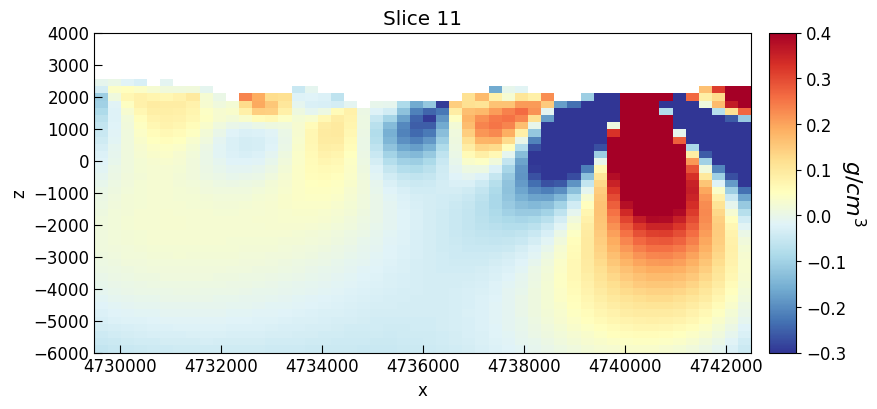

In [72]:
# Plot Recovered Model
fig = plt.figure(figsize=(9, 4))
ax1 = fig.add_axes([0.1, 0.1, 0.73, 0.8])

norm = mpl.colors.Normalize(
    vmin=np.min(recovered_tree_model), vmax=np.max(recovered_tree_model)
    )

# norm = mpl.colors.Normalize(vmin=-0.3, vmax=0.4)

tree_mesh.plot_slice(
    tree_plotting_map * recovered_tree_model,
    normal="y",
    ax=ax1,
    slice_loc=2051291,
    grid=False,
    pcolor_opts={"cmap": mpl.cm.RdYlBu_r, "norm": norm},
)

ax1.tick_params(axis='both', direction='in', length=6)
ax1.ticklabel_format(style='plain', axis='both')
# Para más marcas
ax1.locator_params(axis='y', nbins=10)
ax1.locator_params(axis='x', nbins=8)
ax1.set_ylim(-6000, 4000)

ax2 = fig.add_axes([0.85, 0.1, 0.03, 0.8])
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.RdYlBu_r
)
cbar.set_label("$g/cm^3$", rotation=270, labelpad=15, size=16)

# Ensure the folder exists
output_folder = "figuras_2"
os.makedirs(output_folder, exist_ok=True)

# Save the figure in the folder
plt.savefig(os.path.join(output_folder, 'y2051291_inicial_maxIter=20_alpha=1e-5_beta=1e-4_LSshorten=None.svg'), dpi=500)

plt.show()

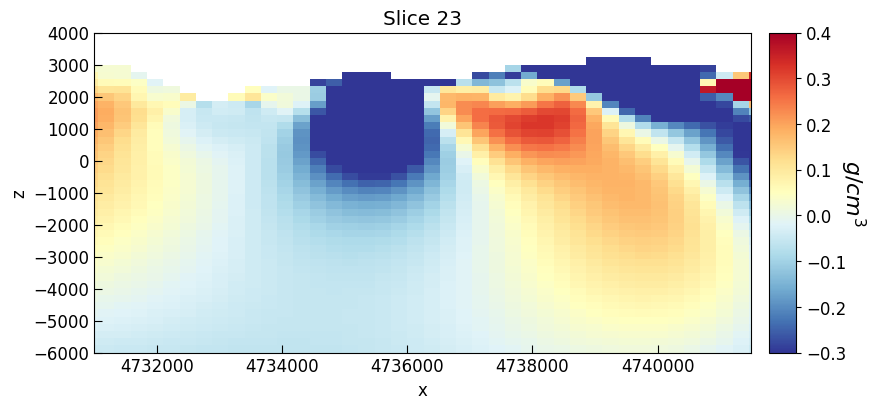

In [73]:
# Plot Recovered Model
fig = plt.figure(figsize=(9, 4))
ax1 = fig.add_axes([0.1, 0.1, 0.73, 0.8])

norm = mpl.colors.Normalize(
    vmin=np.min(recovered_tree_model), vmax=np.max(recovered_tree_model)
    )

# norm = mpl.colors.Normalize(vmin=-0.3, vmax=0.4)

tree_mesh.plot_slice(
    tree_plotting_map * recovered_tree_model,
    normal="y",
    ax=ax1,
    slice_loc=2054372,
    grid=False,
    pcolor_opts={"cmap": mpl.cm.RdYlBu_r, "norm": norm},
)

ax1.tick_params(axis='both', direction='in', length=6)
ax1.ticklabel_format(style='plain', axis='both')
# Para más marcas
ax1.locator_params(axis='y', nbins=10)
ax1.locator_params(axis='x', nbins=8)
ax1.set_ylim(-6000, 4000)
ax1.set_xlim(4731000, 4741500)

ax2 = fig.add_axes([0.85, 0.1, 0.03, 0.8])
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.RdYlBu_r
)
cbar.set_label("$g/cm^3$", rotation=270, labelpad=15, size=16)

# Ensure the folder exists
output_folder = "figuras_2"
os.makedirs(output_folder, exist_ok=True)

# Save the figure in the folder
plt.savefig(os.path.join(output_folder, 'y2054272_inicial_maxIter=20_alpha=1e-5_beta=1e-4_LSshorten=None.svg'), dpi=500)

plt.show()

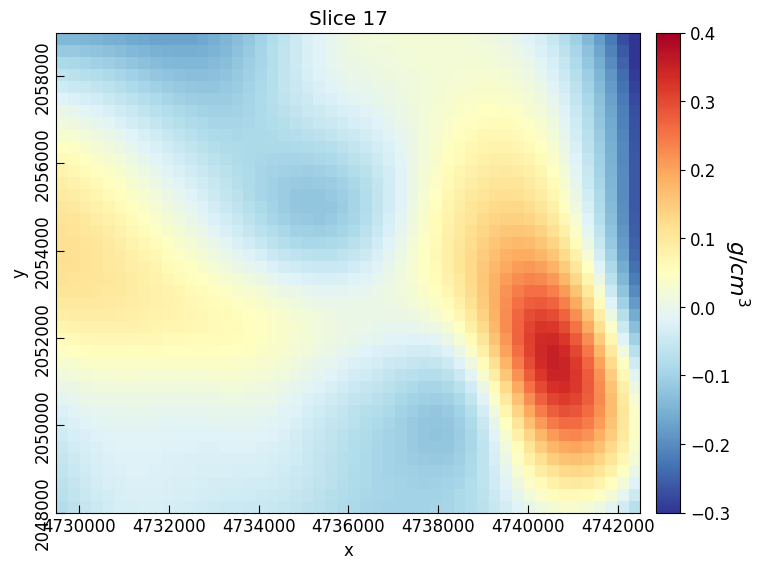

In [74]:
# Plot Recovered Model
fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_axes([0.1, 0.1, 0.73, 0.8])

norm = mpl.colors.Normalize(
    vmin=np.min(recovered_tree_model), vmax=np.max(recovered_tree_model)
    )


tree_mesh.plot_slice(
    tree_plotting_map * recovered_tree_model,
    normal="z",
    dataloc=True,
    ax=ax1,
    slice_loc=-2000,
    grid=False,
    pcolor_opts={"cmap": mpl.cm.RdYlBu_r, "norm": norm},
)

ax1.tick_params(axis='both', direction='in', length=6)
ax1.ticklabel_format(style='plain', axis='both')
# Para más marcas
ax1.locator_params(axis='y', nbins=10)
ax1.locator_params(axis='x', nbins=8)
# Para rotar los números del eje Y
plt.setp(ax1.get_yticklabels(), rotation=90, verticalalignment='center')


ax2 = fig.add_axes([0.85, 0.1, 0.03, 0.8])
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.RdYlBu_r
)
cbar.set_label("$g/cm^3$", rotation=270, labelpad=15, size=16)

# # Ensure the folder exists
# output_folder = "figuras_2"
# os.makedirs(output_folder, exist_ok=True)

# # Save the figure in the folder
# plt.savefig(os.path.join(output_folder, 'z-2000_inicial_maxIter=20_alpha=1e-5_beta=1e-4_LSshorten=None.svg'), dpi=500)

plt.show()

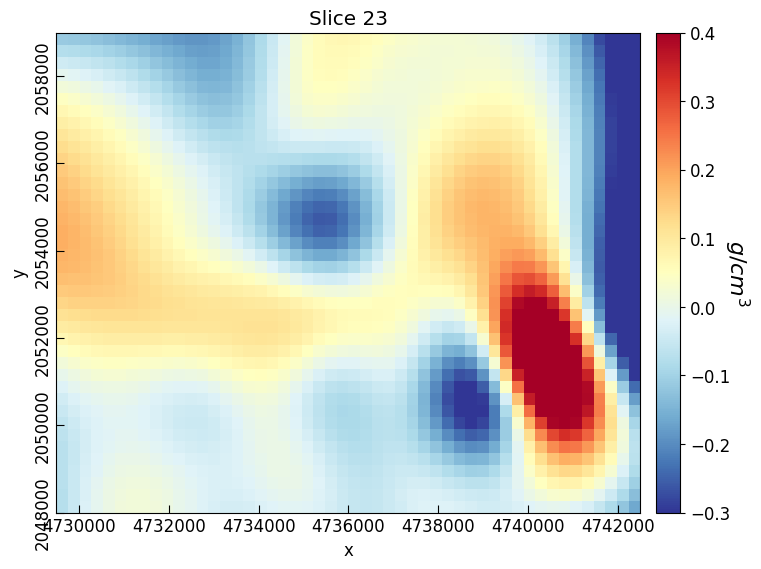

In [75]:
# Plot Recovered Model
fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_axes([0.1, 0.1, 0.73, 0.8])

norm = mpl.colors.Normalize(
    vmin=np.min(recovered_tree_model), vmax=np.max(recovered_tree_model)
    )


tree_mesh.plot_slice(
    tree_plotting_map * recovered_tree_model,
    normal="z",
    dataloc=True,
    ax=ax1,
    slice_loc=-600,
    grid=False,
    pcolor_opts={"cmap": mpl.cm.RdYlBu_r, "norm": norm},
)

ax1.tick_params(axis='both', direction='in', length=6)
ax1.ticklabel_format(style='plain', axis='both')
# Para más marcas
ax1.locator_params(axis='y', nbins=10)
ax1.locator_params(axis='x', nbins=8)
# Para rotar los números del eje Y
plt.setp(ax1.get_yticklabels(), rotation=90, verticalalignment='center')


ax2 = fig.add_axes([0.85, 0.1, 0.03, 0.8])
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.RdYlBu_r
)
cbar.set_label("$g/cm^3$", rotation=270, labelpad=15, size=16)

# # Ensure the folder exists
# output_folder = "figuras_2"
# os.makedirs(output_folder, exist_ok=True)

# # Save the figure in the folder
# plt.savefig(os.path.join(output_folder, 'z-600_inicial_maxIter=20_alpha=1e-5_beta=1e-4_LSshorten=None.svg'), dpi=500)

plt.show()

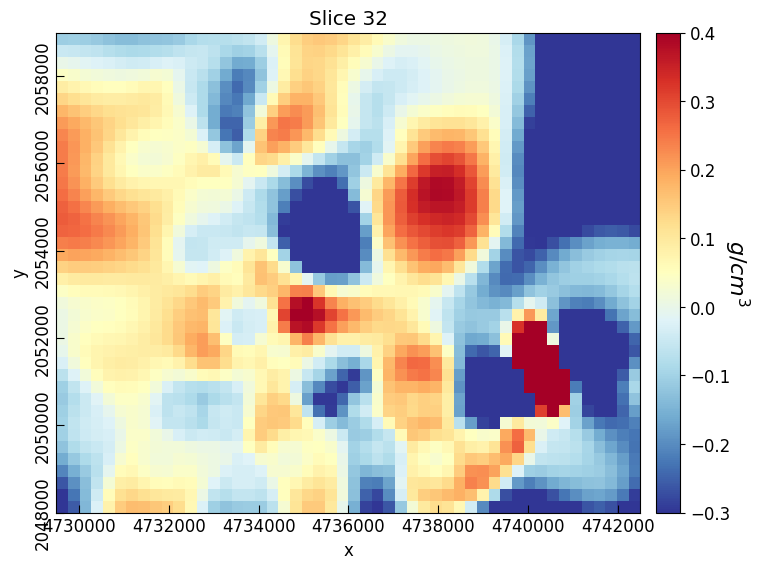

In [76]:
# Plot Recovered Model
fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_axes([0.1, 0.1, 0.73, 0.8])

norm = mpl.colors.Normalize(
    vmin=np.min(recovered_tree_model), vmax=np.max(recovered_tree_model)
    )


tree_mesh.plot_slice(
    tree_plotting_map * recovered_tree_model,
    normal="z",
    dataloc=True,
    ax=ax1,
    slice_loc=1260,
    grid=False,
    pcolor_opts={"cmap": mpl.cm.RdYlBu_r, "norm": norm},
)

ax1.tick_params(axis='both', direction='in', length=6)
ax1.ticklabel_format(style='plain', axis='both')
# Para más marcas
ax1.locator_params(axis='y', nbins=10)
ax1.locator_params(axis='x', nbins=8)
# Para rotar los números del eje Y
plt.setp(ax1.get_yticklabels(), rotation=90, verticalalignment='center')


ax2 = fig.add_axes([0.85, 0.1, 0.03, 0.8])
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.RdYlBu_r
)
cbar.set_label("$g/cm^3$", rotation=270, labelpad=15, size=16)

# # Ensure the folder exists
# output_folder = "figuras_2"
# os.makedirs(output_folder, exist_ok=True)

# # Save the figure in the folder
# plt.savefig(os.path.join(output_folder, 'z1260_inicial_maxIter=20_alpha=1e-5_beta=1e-4_LSshorten=None.svg'), dpi=500)

plt.show()

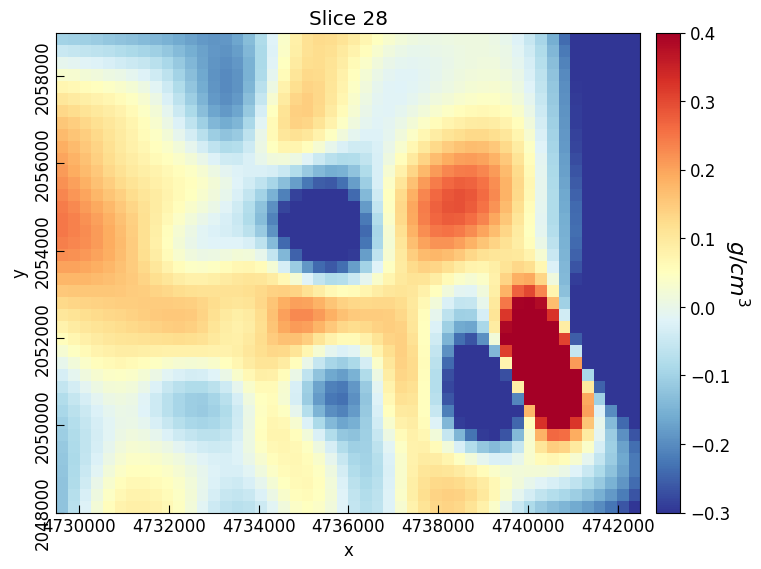

In [77]:
# Plot Recovered Model
fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_axes([0.1, 0.1, 0.73, 0.8])

norm = mpl.colors.Normalize(
    vmin=np.min(recovered_tree_model), vmax=np.max(recovered_tree_model)
    )


tree_mesh.plot_slice(
    tree_plotting_map * recovered_tree_model,
    normal="z",
    dataloc=True,
    ax=ax1,
    slice_loc=500,
    grid=False,
    pcolor_opts={"cmap": mpl.cm.RdYlBu_r, "norm": norm},
)

ax1.tick_params(axis='both', direction='in', length=6)
ax1.ticklabel_format(style='plain', axis='both')
# Para más marcas
ax1.locator_params(axis='y', nbins=10)
ax1.locator_params(axis='x', nbins=8)
# Para rotar los números del eje Y
plt.setp(ax1.get_yticklabels(), rotation=90, verticalalignment='center')


ax2 = fig.add_axes([0.85, 0.1, 0.03, 0.8])
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.RdYlBu_r
)
cbar.set_label("$g/cm^3$", rotation=270, labelpad=15, size=16)

# Ensure the folder exists
# output_folder = "figuras_2"
# os.makedirs(output_folder, exist_ok=True)

# # Save the figure in the folder
# plt.savefig(os.path.join(output_folder, 'z500_inicial_maxIter=20_alpha=1e-5_beta=1e-4_LSshorten=None.svg'), dpi=500)

plt.show()

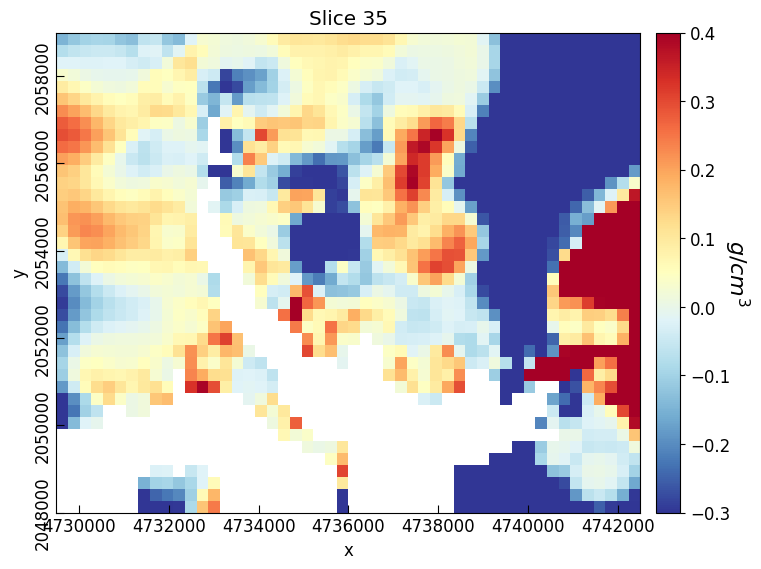

In [78]:
# Plot Recovered Model
fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_axes([0.1, 0.1, 0.73, 0.8])

norm = mpl.colors.Normalize(
    vmin=np.min(recovered_tree_model), vmax=np.max(recovered_tree_model)
    )


tree_mesh.plot_slice(
    tree_plotting_map * recovered_tree_model,
    normal="z",
    dataloc=True,
    ax=ax1,
    slice_loc=1930,
    grid=False,
    pcolor_opts={"cmap": mpl.cm.RdYlBu_r, "norm": norm},
)

ax1.tick_params(axis='both', direction='in', length=6)
ax1.ticklabel_format(style='plain', axis='both')
# Para más marcas
ax1.locator_params(axis='y', nbins=10)
ax1.locator_params(axis='x', nbins=8)
# Para rotar los números del eje Y
plt.setp(ax1.get_yticklabels(), rotation=90, verticalalignment='center')


ax2 = fig.add_axes([0.85, 0.1, 0.03, 0.8])
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.RdYlBu_r
)
cbar.set_label("$g/cm^3$", rotation=270, labelpad=15, size=16)

# Ensure the folder exists
# output_folder = "figuras_2"
# os.makedirs(output_folder, exist_ok=True)

# # Save the figure in the folder
# plt.savefig(os.path.join(output_folder, 'z1930_inicial_maxIter=20_alpha=1e-5_beta=1e-4_LSshorten=None.svg'), dpi=500)

plt.show()

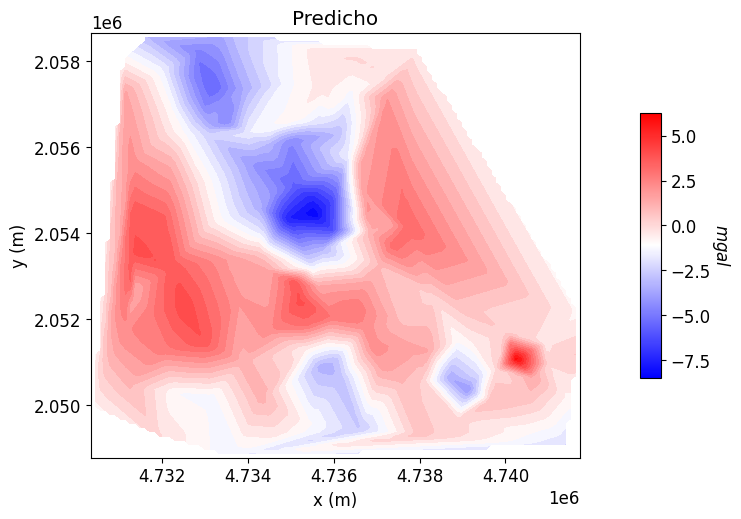

In [79]:
dpred_new = (-inv_prob_irls.dpred)

# Plot
mpl.rcParams.update({"font.size": 12})
fig = plt.figure(figsize=(7, 5))

v_lim = [np.min(dpred_new), np.max(dpred_new), np.min(-dpred_new), np.max(-dpred_new)]

ax1 = fig.add_axes([0.1, 0.1, 0.73, 0.85])
plot2Ddata(
    receiver_list[0].locations,
    dpred_new,
    ax=ax1,
    ncontour=30,
    clim=(v_lim[0], v_lim[1]),
    contourOpts={"cmap": "bwr"})
ax1.set_title("Predicho")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("y (m)")

ax2 = fig.add_axes([0.9, 0.26, 0.03, 0.53])
norm = mpl.colors.Normalize(vmin=v_lim[0], vmax=v_lim[1])
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.bwr,
)
cbar.set_label("$mgal$", rotation=270, labelpad=15, size=12)

plt.show()

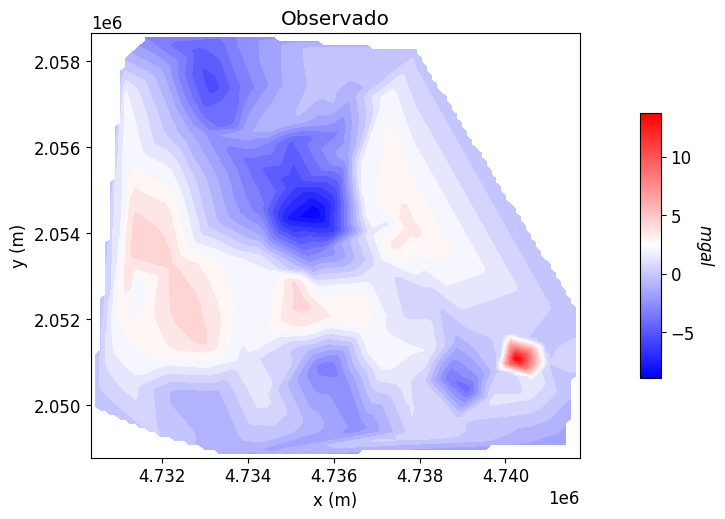

In [80]:
mpl.rcParams.update({"font.size": 12})
fig = plt.figure(figsize=(7, 5))

ax1 = fig.add_axes([0.1, 0.1, 0.73, 0.85])
plot2Ddata(receiver_locations, dobs, ax=ax1, ncontour=30, contourOpts={"cmap": "bwr"})
ax1.set_title("Observado")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("y (m)")

ax2 = fig.add_axes([0.9, 0.26, 0.03, 0.53])
norm = mpl.colors.Normalize(vmin=-np.max(-dobs), vmax=np.max(dobs))
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.bwr,
)
cbar.set_label("$mgal$", rotation=270, labelpad=15, size=12)

plt.show()

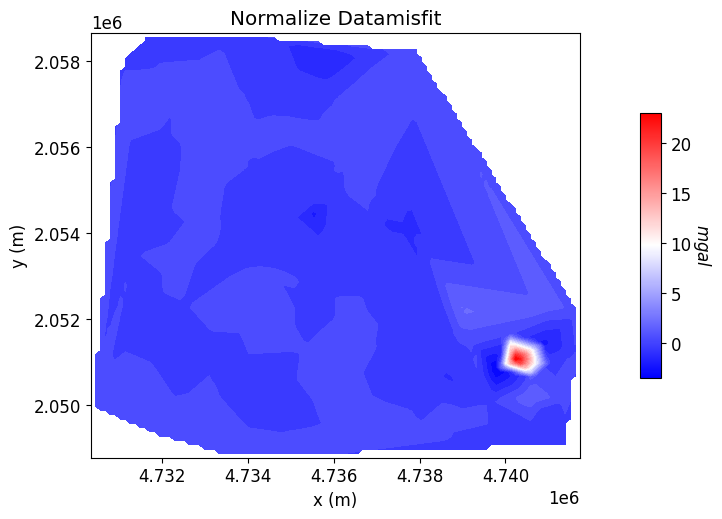

In [81]:
data_misfit_new= (dobs - dpred_new) / sigma

mpl.rcParams.update({"font.size": 12})
fig = plt.figure(figsize=(7, 5))

ax1 = fig.add_axes([0.1, 0.1, 0.73, 0.85])
plot2Ddata(receiver_locations,
           data_misfit_new,
           ax=ax1,
           ncontour=30,
           contourOpts={"cmap": "bwr"})
ax1.set_title("Normalize Datamisfit")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("y (m)")

ax2 = fig.add_axes([0.9, 0.26, 0.03, 0.53])
norm = mpl.colors.Normalize(vmin=-np.max(-data_misfit_new), vmax=np.max(data_misfit_new))
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.bwr,
)
cbar.set_label("$mgal$", rotation=270, labelpad=15, size=12)

plt.show()

In [82]:
models = {'Densidad':tree_plotting_map*recovered_tree_model}
databse = mesh.to_vtk(models)
databse.save('modelo_1_2.vtk')

In [83]:
# Calcular datos predichos
dpred_new = simulation_L2.dpred(recovered_tree_model)
# dpred_new = (-inv_prob_irls.dpred)
# Calcular residuales
residuals = data_object.dobs - dpred_new

# Calcular RMS
rms = np.sqrt(np.mean(residuals**2))

print(f"RMS = {rms:.4f} mGal")

RMS = 0.6476 mGal


In [84]:
# RMS normalizado (chi-factor)
rms_normalizado = np.sqrt(np.mean((residuals / uncertainties)**2))

print(f"RMS normalizado (χ) = {rms_normalizado:.3f}")

RMS normalizado (χ) = 0.941


In [85]:
target_misfit.target

135.0

In [86]:
def plot_tikhonov_curve(iteration, scale):
    phi_d = []
    phi_m = []
    beta = []
    iterations = np.arange(len(save_iteration_new.outDict)) + 1
    for kk in iterations:
        phi_d.append(save_iteration_new.outDict[kk]['phi_d'])
        phi_m.append(save_iteration_new.outDict[kk]['phi_m'])
        beta.append(save_iteration_new.outDict[kk]['beta'])

    fig, axs = plt.subplots(1, 2, figsize=(12,5))

    # Primera gráfica
    axs[0].plot(phi_m, phi_d, 'k.-')
    axs[0].plot(phi_m[iteration-1], phi_d[iteration-1], 'go', ms=10)
    axs[0].set_xlabel("$\phi_m$")
    axs[0].set_ylabel("$\phi_d$")
    axs[0].grid(True)

    # Segunda gráfica
    line1 = axs[1].plot(iterations, phi_d, 'k.-', label='$\phi_d$')
    point1 = axs[1].plot(iterations[iteration-1], phi_d[iteration-1], 'go', ms=10)

    ax_1 = axs[1].twinx()
    line2 = ax_1.plot(iterations, phi_m, 'r.-', label='$\phi_m$')
    point2 = ax_1.plot(iterations[iteration-1], phi_m[iteration-1], 'go', ms=10)

    axs[1].set_ylabel("$\phi_d$")
    ax_1.set_ylabel("$\phi_m$")
    axs[1].set_xlabel("Iterations")
    axs[1].grid(True)

    # Añadir leyendas
    lines = line1 + line2
    labels = [line.get_label() for line in lines]
    axs[1].legend(lines, labels, loc='upper left')

    axs[0].set_title(
        "$\phi_d$={:.1e}, $\phi_m$={:.1e}, $\\beta$={:.1e}".format(phi_d[iteration-1], phi_m[iteration-1], beta[iteration-1]),
        fontsize = 14
    )
    axs[1].set_title("Target misfit={:.0f}".format(survey.nD/2))

    for ii, ax in enumerate(axs):
        if ii == 0:
            ax.set_xscale(scale)
        ax.set_yscale(scale)
        xlim = ax.get_xlim()
        ax.hlines(survey.nD/2, xlim[0], xlim[1], linestyle='--', label='$\phi_d^{*}$')
        ax.set_xlim(xlim)

    axs[0].legend()
    plt.tight_layout()

interact(
    plot_tikhonov_curve,
    iteration=widgets.IntSlider(min=1, max=len(save_iteration_new.outDict), step=1),
    scale=widgets.RadioButtons(options=["linear", "log"])
)

interactive(children=(IntSlider(value=1, description='iteration', max=20, min=1), RadioButtons(description='sc…

<function __main__.plot_tikhonov_curve(iteration, scale)>

In [89]:
save_current_svg('nombre_archivo2.svg')

✓ Guardado: figures/nombre_archivo2.svg.png
  Tamaño del archivo: 154.6 KB
